Epoch 001 | train_loss=0.5793 | val_loss=0.5011 | val_macro_acc=0.627
Epoch 002 | train_loss=0.5317 | val_loss=0.4592 | val_macro_acc=0.689
Epoch 003 | train_loss=0.5047 | val_loss=0.4404 | val_macro_acc=0.712
Epoch 004 | train_loss=0.4842 | val_loss=0.4291 | val_macro_acc=0.706
Epoch 005 | train_loss=0.4681 | val_loss=0.4212 | val_macro_acc=0.729
Epoch 006 | train_loss=0.4555 | val_loss=0.4153 | val_macro_acc=0.729
Epoch 007 | train_loss=0.4454 | val_loss=0.4109 | val_macro_acc=0.814
Epoch 008 | train_loss=0.4374 | val_loss=0.4075 | val_macro_acc=0.821
Epoch 009 | train_loss=0.4310 | val_loss=0.4050 | val_macro_acc=0.821
Epoch 010 | train_loss=0.4259 | val_loss=0.4032 | val_macro_acc=0.821
Epoch 011 | train_loss=0.4217 | val_loss=0.4018 | val_macro_acc=0.821
Epoch 012 | train_loss=0.4182 | val_loss=0.4008 | val_macro_acc=0.815
Epoch 013 | train_loss=0.4154 | val_loss=0.4000 | val_macro_acc=0.815
Epoch 014 | train_loss=0.4130 | val_loss=0.3995 | val_macro_acc=0.815
Epoch 015 | train_lo

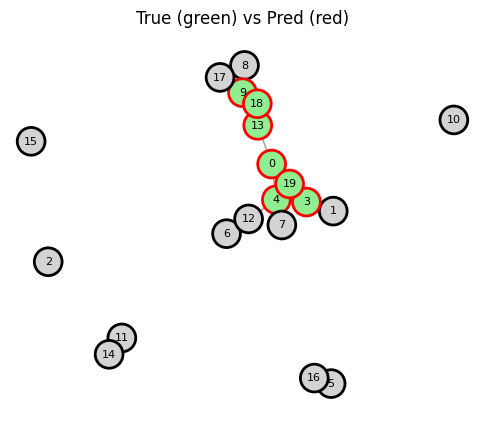

Graph verify: TP=3 FP=1 TN=13 FN=3 | motifs: tri=1, sq=1


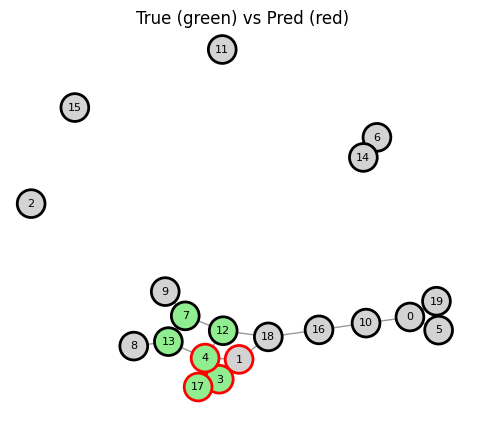

Graph verify: TP=4 FP=1 TN=13 FN=2 | motifs: tri=1, sq=1


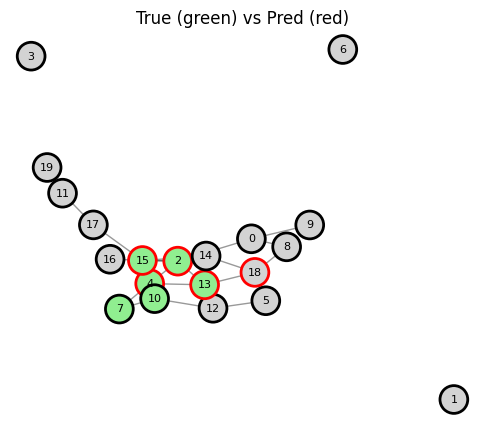

In [3]:
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import networkx as nx
import pennylane as qml

# Optional: visualization
import matplotlib.pyplot as plt

# =========================================================
# Utilities
# =========================================================

def set_seeds(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def macro_accuracy(y_true, y_pred, num_classes=2):
    cm = confusion_matrix(y_true, y_pred, num_classes=num_classes)
    per_class = []
    for c in range(num_classes):
        support = cm[c, :].sum()
        correct = cm[c, c]
        acc_c = correct / support if support > 0 else 0.0
        per_class.append(acc_c)
    return float(np.mean(per_class))

def print_confusion(cm):
    num_classes = cm.shape[0]
    print("Confusion matrix (rows=true, cols=pred):")
    for i in range(num_classes):
        row = " ".join(f"{cm[i, j]:4d}" for j in range(num_classes))
        print(f"class {i}: {row}")

# =========================================================
# Motif planting and labeling
# =========================================================

def plant_triangle(G, rng):
    # Choose 3 distinct nodes and ensure edges form a triangle
    nodes = list(G.nodes())
    if len(nodes) < 3: 
        return None
    u, v, w = rng.choice(nodes, size=3, replace=False)
    G.add_edge(u, v)
    G.add_edge(v, w)
    G.add_edge(w, u)
    return (u, v, w)

def plant_4cycle(G, rng):
    # Choose 4 distinct nodes and connect in a ring
    nodes = list(G.nodes())
    if len(nodes) < 4: 
        return None
    a, b, c, d = rng.choice(nodes, size=4, replace=False)
    G.add_edge(a, b)
    G.add_edge(b, c)
    G.add_edge(c, d)
    G.add_edge(d, a)
    return (a, b, c, d)

def label_nodes_by_motifs(G, motifs):
    # motifs: dict with "triangles": list of tuples, "squares": list of tuples
    N = G.number_of_nodes()
    y = np.zeros(N, dtype=np.int64)
    for tri in motifs.get("triangles", []):
        for n in tri:
            y[n] = 1
    for sq in motifs.get("squares", []):
        for n in sq:
            y[n] = 1
    return y

def compute_node_features(G):
    # Structural features: degree norm, clustering coefficient, eigenvector centrality
    N = G.number_of_nodes()
    degs = np.array([G.degree(i) for i in range(N)], dtype=np.float32)
    deg_norm = (degs / max(1, N - 1)).astype(np.float32)
    clustering = np.array(list(nx.clustering(G).values()), dtype=np.float32)
    # eigenvector centrality might fail on disconnected small components; fallback to zeros
    try:
        ev = nx.eigenvector_centrality_numpy(G)
        ev_vec = np.array([ev[i] for i in range(N)], dtype=np.float32)
    except Exception:
        ev_vec = np.zeros(N, dtype=np.float32)
    X = np.stack([deg_norm, clustering, ev_vec], axis=1).astype(np.float32)
    return X

def make_motif_graph(N, p_backbone, n_triangles=1, n_squares=1, seed=None):
    """
    Create a synthetic graph with background Erdos-Renyi edges plus planted motifs.
    Returns: edge_index [2,E], X [N,3], y [N], G (networkx), motifs dict.
    """
    rng = np.random.default_rng(seed)
    G = nx.Graph()
    G.add_nodes_from(range(N))
    # Background edges
    for i in range(N):
        for j in range(i + 1, N):
            if rng.random() < p_backbone:
                G.add_edge(i, j)
    motifs = {"triangles": [], "squares": []}
    # Plant triangles
    for _ in range(n_triangles):
        tri = plant_triangle(G, rng)
        if tri:
            motifs["triangles"].append(tri)
    # Plant squares (4-cycles)
    for _ in range(n_squares):
        sq = plant_4cycle(G, rng)
        if sq:
            motifs["squares"].append(sq)
    # Features and labels
    X = compute_node_features(G)
    y = label_nodes_by_motifs(G, motifs)
    # Edge index
    edges = np.array(list(G.edges()), dtype=np.int64).T if G.number_of_edges() > 0 else np.zeros((2,0), dtype=np.int64)
    edges_rev = edges[::-1]
    edge_index = np.concatenate([edges, edges_rev], axis=1) if edges.shape[1] > 0 else edges
    return edge_index, X, y, G, motifs

def make_motif_dataset(num_graphs=40, N=20, p_backbone=0.08, n_triangles=1, n_squares=1, seed=0):
    set_seeds(seed)
    graphs = []
    for g in range(num_graphs):
        ei, X, y, G, motifs = make_motif_graph(
            N=N, p_backbone=p_backbone,
            n_triangles=n_triangles, n_squares=n_squares,
            seed=seed + 1000 + g
        )
        graphs.append(dict(edge_index=ei, X=X, y=y, G=G, motifs=motifs))
    return graphs

def train_val_test_split_graphs(num_graphs, splits=(0.6, 0.2, 0.2), seed=0):
    idx = np.arange(num_graphs)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    n_train = int(splits[0] * num_graphs)
    n_val = int(splits[1] * num_graphs)
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train + n_val]
    test_idx = idx[n_train + n_val:]
    return train_idx, val_idx, test_idx

# =========================================================
# Quantum Message-Passing Node Classifier (same model as before)
# =========================================================

class QMessagePassingNodeClassifier(nn.Module):
    """
    Quantum message-passing node classifier (1 qubit/node):
    - T layers: encode (RX/RY) -> edge entanglers (ControlledPhaseShift) -> mixing (H).
    - Per-node readout: expval(Z) -> linear head with original features to logits.
    """
    def __init__(self, n_nodes, in_feats=3, T=2, seed=0, verbose=False, use_gpu_qnode=False):
        super().__init__()
        self.verbose = verbose
        self.n_nodes = n_nodes
        self.total_qubits = n_nodes
        self.T = T

        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # Classical parts
        self.encoders = nn.ModuleList([nn.Linear(in_feats, 2) for _ in range(T)])
        self.edge_phases = nn.ParameterList([nn.Parameter(torch.randn(1) * 0.1) for _ in range(T)])
        self.readout = nn.Linear(1 + in_feats, 2)

        # Quantum device
        dev_name = "default.qubit"
        if use_gpu_qnode:
            dev_name = "lightning.gpu"  # requires: pip install pennylane-lightning[gpu]
        self.dev = qml.device(dev_name, wires=self.total_qubits, shots=None)

        @qml.qnode(self.dev, interface="torch", diff_method="best")
        def circuit(edge_index, enc_alphas, enc_betas, edge_phi):
            # Encode
            for i in range(self.n_nodes):
                qml.RX(enc_alphas[i], wires=i)
                qml.RY(enc_betas[i], wires=i)
            # Edge entanglers
            E = edge_index.shape[1]
            for e in range(E):
                u = int(edge_index[0, e].item())
                v = int(edge_index[1, e].item())
                if u != v:
                    qml.ControlledPhaseShift(edge_phi, wires=[u, v])
            # Mixing
            for i in range(self.n_nodes):
                qml.Hadamard(wires=i)
            # Readout
            return [qml.expval(qml.Z(i)) for i in range(self.n_nodes)]

        self._circuit = circuit

    def forward(self, edge_index_torch, x_torch):
        model_device = next(self.parameters()).device

        # Run encoders on model device
        x_model = x_torch.to(model_device).float()
        last_expvals_cpu = None

        for t in range(self.T):
            enc = self.encoders[t](x_model)           # [N,2] on model_device
            enc_alphas_model = enc[:, 0]
            enc_betas_model  = enc[:, 1]
            edge_phi_model   = self.edge_phases[t].squeeze()

            # Move QNode inputs to CPU (robust path)
            edge_index_cpu = edge_index_torch.detach().to("cpu")
            enc_alphas_cpu = enc_alphas_model.detach().to("cpu")
            enc_betas_cpu  = enc_betas_model.detach().to("cpu")
            edge_phi_cpu   = edge_phi_model.detach().to("cpu")

            # QNode call
            layer_out = self._circuit(edge_index_cpu, enc_alphas_cpu, enc_betas_cpu, edge_phi_cpu)
            last_expvals_cpu = torch.stack(layer_out, dim=0).float()  # [N] CPU

        # Readout on model device
        expvals = last_expvals_cpu.to(model_device).unsqueeze(1)  # [N,1]
        readin = torch.cat([expvals, x_model], dim=1)              # [N, 1+F]
        logits = self.readout(readin)                              # [N,2]
        return logits

# =========================================================
# Train/evaluate over graphs (graph-level split; node-level supervision)
# =========================================================

def train_epoch(model, graphs, optimizer, device="cpu"):
    model.train()
    total_loss = 0.0
    total_nodes = 0
    for g in graphs:
        edge_index = torch.from_numpy(g["edge_index"]).long().to(device)
        X = torch.from_numpy(g["X"]).float().to(device)
        y = torch.from_numpy(g["y"]).long().to(device)

        logits = model(edge_index, X)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.shape[0]
        total_nodes += X.shape[0]
    return total_loss / max(1, total_nodes)

@torch.no_grad()
def evaluate(model, graphs, device="cpu"):
    model.eval()
    all_true = []
    all_pred = []
    total_loss = 0.0
    total_nodes = 0

    for g in graphs:
        edge_index = torch.from_numpy(g["edge_index"]).long().to(device)
        X = torch.from_numpy(g["X"]).float().to(device)
        y = torch.from_numpy(g["y"]).long().to(device)

        logits = model(edge_index, X)
        loss = F.cross_entropy(logits, y)

        pred = logits.argmax(dim=1).cpu().numpy()
        all_pred.extend(list(pred))
        all_true.extend(list(y.cpu().numpy()))

        total_loss += loss.item() * X.shape[0]
        total_nodes += X.shape[0]

    avg_loss = total_loss / max(1, total_nodes)
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    mac_acc = macro_accuracy(all_true, all_pred, num_classes=2)
    cm = confusion_matrix(all_true, all_pred, num_classes=2)
    return avg_loss, mac_acc, cm, all_true, all_pred

# =========================================================
# Verification utilities
# =========================================================

def per_graph_verification(model, graphs, device="cpu", max_print=3, draw=False):
    """
    Prints a few graphs with:
    - counts of TP/FP/TN/FN
    - optional drawing with predicted vs true motif nodes highlighted
    """
    shown = 0
    for g in graphs:
        if shown >= max_print:
            break
        edge_index = torch.from_numpy(g["edge_index"]).long().to(device)
        X = torch.from_numpy(g["X"]).float().to(device)
        y = torch.from_numpy(g["y"]).long().to(device)

        with torch.no_grad():
            logits = model(edge_index, X)
            pred = logits.argmax(dim=1).cpu().numpy()
            y_np = y.cpu().numpy()

        tp = int(((pred == 1) & (y_np == 1)).sum())
        fp = int(((pred == 1) & (y_np == 0)).sum())
        tn = int(((pred == 0) & (y_np == 0)).sum())
        fn = int(((pred == 0) & (y_np == 1)).sum())
        print(f"Graph verify: TP={tp} FP={fp} TN={tn} FN={fn} | motifs: tri={len(g['motifs']['triangles'])}, sq={len(g['motifs']['squares'])}")

        if draw:
            draw_graph_with_predictions(g["G"], y_np, pred, title="True (green) vs Pred (red)")
        shown += 1

def draw_graph_with_predictions(G, y_true, y_pred, title=""):
    pos = nx.spring_layout(G, seed=0)
    plt.figure(figsize=(6, 5))
    # Node colors: base gray; green overlay if true=1; red border if pred=1
    node_color = ['lightgray' if y_true[i] == 0 else 'lightgreen' for i in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=400, edgecolors=[
        'red' if y_pred[i] == 1 else 'black' for i in G.nodes()
    ], linewidths=2)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, labels={i: i for i in G.nodes()}, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# =========================================================
# Main experiment
# =========================================================

def run_motif_experiment(
    num_graphs=60,
    splits=(0.6, 0.2, 0.2),
    N_fixed=20,
    p_backbone=0.08,
    n_triangles=1,
    n_squares=1,
    T=2,
    epochs=60,
    lr=0.03,
    seed=42,
    device="cpu",
    use_gpu_qnode=False,
    verbose=True,
    verify_draw=False
):
    set_seeds(seed)

    dataset = make_motif_dataset(
        num_graphs=num_graphs, N=N_fixed, p_backbone=p_backbone,
        n_triangles=n_triangles, n_squares=n_squares, seed=seed
    )

    train_idx, val_idx, test_idx = train_val_test_split_graphs(num_graphs, splits=splits, seed=seed)
    train_graphs = [dataset[i] for i in train_idx]
    val_graphs   = [dataset[i] for i in val_idx]
    test_graphs  = [dataset[i] for i in test_idx]

    model = QMessagePassingNodeClassifier(
        n_nodes=N_fixed, in_feats=3, T=T, seed=seed, verbose=verbose, use_gpu_qnode=use_gpu_qnode
    ).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = (-1.0, None)  # (macro-acc, state_dict)
    for ep in range(1, epochs + 1):
        tr_loss = train_epoch(model, train_graphs, opt, device=device)
        val_loss, val_mac, val_cm, _, _ = evaluate(model, val_graphs, device=device)
        if verbose:
            print(f"Epoch {ep:03d} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_macro_acc={val_mac:.3f}")
        if val_mac > best_val[0]:
            best_val = (val_mac, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()})

    if best_val[1] is not None:
        model.load_state_dict(best_val[1])

    tr_loss, tr_mac, tr_cm, tr_y, tr_pred = evaluate(model, train_graphs, device=device)
    va_loss, va_mac, va_cm, va_y, va_pred = evaluate(model, val_graphs, device=device)
    te_loss, te_mac, te_cm, te_y, te_pred = evaluate(model, test_graphs, device=device)

    print("\nResults (motif detection):")
    print(f"- Train: macro-acc={tr_mac:.3f}, loss={tr_loss:.4f}")
    print_confusion(tr_cm)
    print(f"- Val:   macro-acc={va_mac:.3f}, loss={va_loss:.4f}")
    print_confusion(va_cm)
    print(f"- Test:  macro-acc={te_mac:.3f}, loss={te_loss:.4f}")
    print_confusion(te_cm)

    print("\nVerification on a few held-out test graphs:")
    per_graph_verification(model, test_graphs, device=device, max_print=3, draw=verify_draw)

    return {
        "model": model,
        "splits": (train_idx, val_idx, test_idx),
        "metrics": {
            "train": dict(loss=tr_loss, macro_acc=tr_mac, cm=tr_cm),
            "val":   dict(loss=va_loss, macro_acc=va_mac, cm=va_cm),
            "test":  dict(loss=te_loss, macro_acc=te_mac, cm=te_cm),
        }
    }

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Set use_gpu_qnode=True to try GPU-backed quantum simulator (requires: pip install pennylane-lightning[gpu])
    results = run_motif_experiment(
        num_graphs=60,
        splits=(0.6, 0.2, 0.2),
        N_fixed=20,
        p_backbone=0.08,
        n_triangles=1,
        n_squares=1,
        T=2,
        epochs=60,
        lr=0.03,
        seed=7,
        device=device,
        use_gpu_qnode=False,
        verbose=True,
        verify_draw=True  # set True to visualize a few graphs with true vs predicted motif nodes
    )
